In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_curve, auc, precision_recall_curve, 
                           f1_score, precision_score, recall_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')


## Load Preprocessed Data


In [4]:
df = pd.read_csv("../preprocessed_stroke_data.csv")

print("Dataset Information:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nTarget distribution:")
print(df['Stroke'].value_counts())
print(f"\nTarget distribution (%):")
print(df['Stroke'].value_counts(normalize=True) * 100)

# Check class imbalance
stroke_count = df['Stroke'].sum()
total_count = len(df)
imbalance_ratio = (total_count - stroke_count) / stroke_count
print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1 (No Stroke:Stroke)")
print("This imbalance requires SMOTE.")


Dataset Information:
Shape: (41000, 17)
Columns: ['Age', 'Sex', 'Hypertension', 'Heart_Disease', 'Work_Type', 'Residence_Type', 'Average_Glucose_Level', 'BMI', 'Smoking_Status', 'Physical_Activity', 'Alcohol_Intake', 'Stress_Level', 'Blood_Pressure', 'Cholesterol', 'Family_History', 'MRI_Result', 'Stroke']

Data types:
Age                        int64
Sex                        int64
Hypertension               int64
Heart_Disease              int64
Work_Type                  int64
Residence_Type             int64
Average_Glucose_Level    float64
BMI                      float64
Smoking_Status             int64
Physical_Activity          int64
Alcohol_Intake             int64
Stress_Level             float64
Blood_Pressure             int64
Cholesterol                int64
Family_History             int64
MRI_Result               float64
Stroke                     int64
dtype: object

Missing values:
Age                      0
Sex                      0
Hypertension             0
Heart_

## Prepare Data for Training


In [6]:
# Separate features and target
X = df.drop('Stroke', axis=1)
y = df['Stroke']

# Get feature names
feature_names = X.columns.tolist()
print(f"Features ({len(feature_names)}): {feature_names}")

# Initial train-test split (before SMOTE to avoid data leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTrain set target distribution:")
print(y_train.value_counts())
print(f"\nTest set target distribution:")
print(y_test.value_counts())


Features (16): ['Age', 'Sex', 'Hypertension', 'Heart_Disease', 'Work_Type', 'Residence_Type', 'Average_Glucose_Level', 'BMI', 'Smoking_Status', 'Physical_Activity', 'Alcohol_Intake', 'Stress_Level', 'Blood_Pressure', 'Cholesterol', 'Family_History', 'MRI_Result']

Train set shape: (32800, 16)
Test set shape: (8200, 16)

Train set target distribution:
Stroke
0    29479
1     3321
Name: count, dtype: int64

Test set target distribution:
Stroke
0    7370
1     830
Name: count, dtype: int64


## Apply SMOTE


In [7]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE - Train set shape: {X_train.shape}")
print(f"After SMOTE - Train set shape: {X_train_resampled.shape}")
print(f"\nBefore SMOTE - Train target distribution:")
print(y_train.value_counts())
print(f"\nAfter SMOTE - Train target distribution:")
print(pd.Series(y_train_resampled).value_counts())

# Note: Test set remains unchanged (no SMOTE applied)
print(f"\nTest set remains unchanged: {X_test.shape}")
print("Test set target distribution:")
print(y_test.value_counts())


Before SMOTE - Train set shape: (32800, 16)
After SMOTE - Train set shape: (58958, 16)

Before SMOTE - Train target distribution:
Stroke
0    29479
1     3321
Name: count, dtype: int64

After SMOTE - Train target distribution:
Stroke
0    29479
1    29479
Name: count, dtype: int64

Test set remains unchanged: (8200, 16)
Test set target distribution:
Stroke
0    7370
1     830
Name: count, dtype: int64


## Visualizations After SMOTE


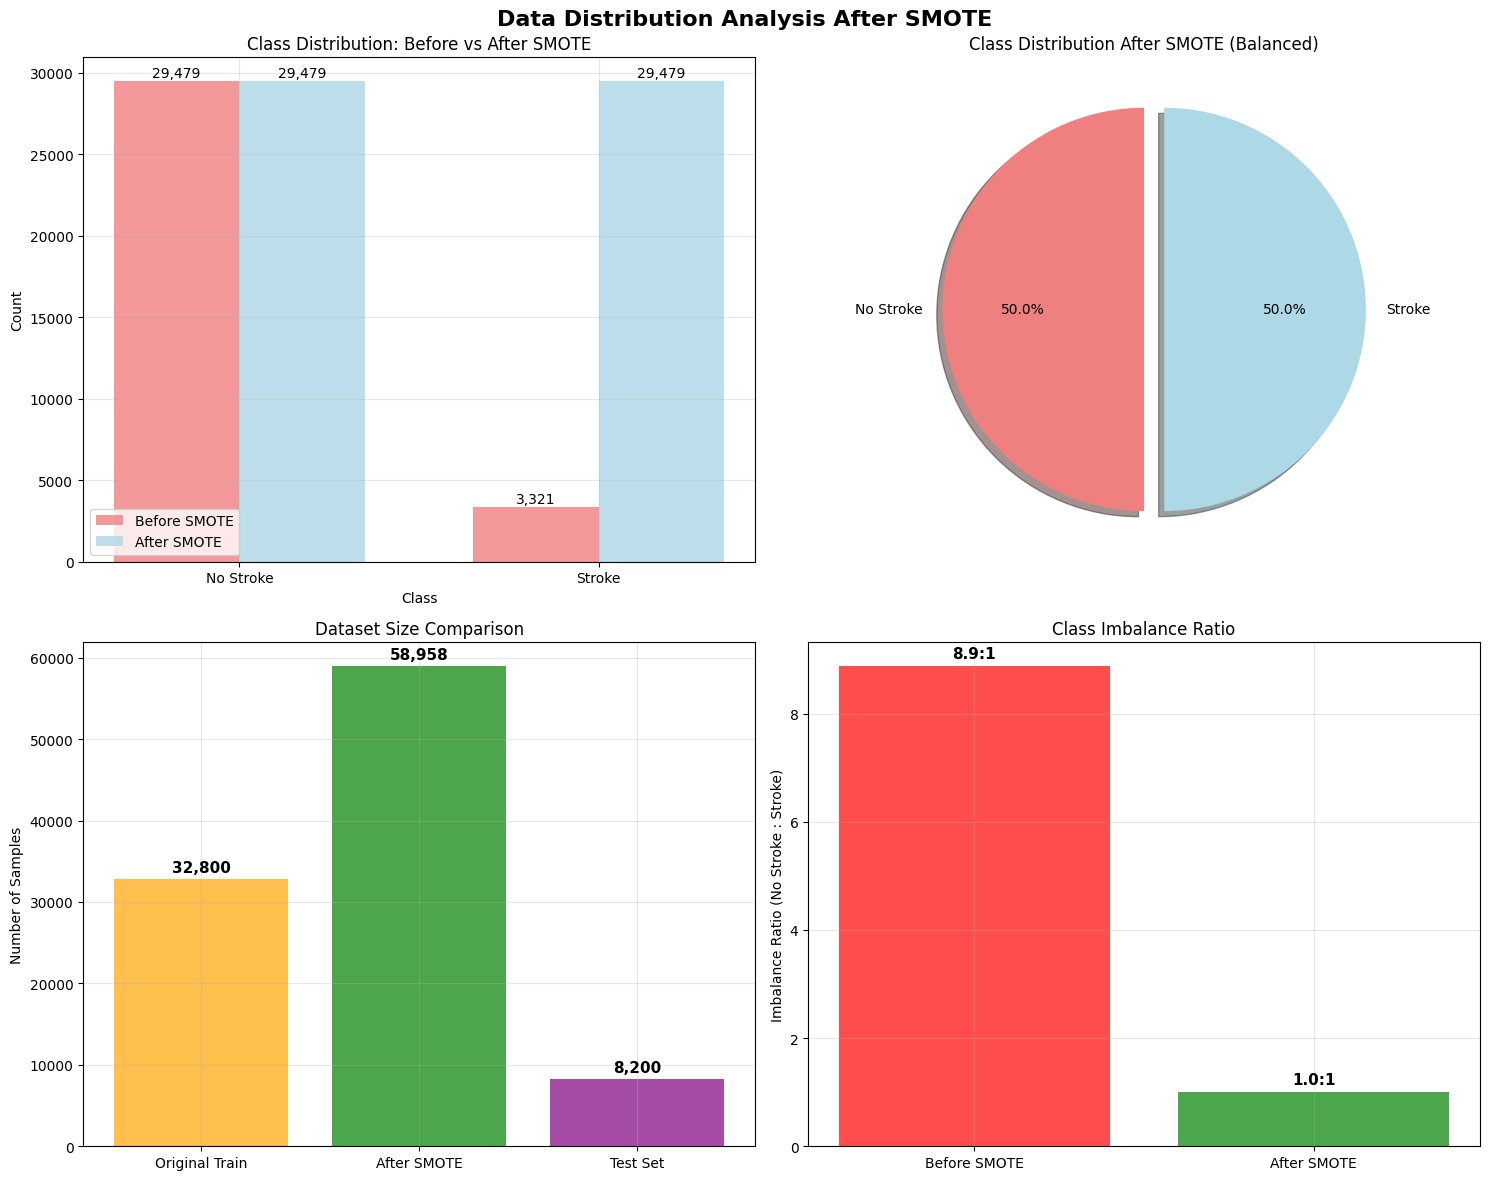

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Data Distribution Analysis After SMOTE', fontsize=16, fontweight='bold')

ax1 = axes[0, 0]
before_counts = y_train.value_counts().sort_index()
after_counts = pd.Series(y_train_resampled).value_counts().sort_index()

x = ['No Stroke', 'Stroke']
before_values = [before_counts[0], before_counts[1]]
after_values = [after_counts[0], after_counts[1]]

x_pos = np.arange(len(x))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, before_values, width, label='Before SMOTE', alpha=0.8, color='lightcoral')
bars2 = ax1.bar(x_pos + width/2, after_values, width, label='After SMOTE', alpha=0.8, color='lightblue')

ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_title('Class Distribution: Before vs After SMOTE')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x)
ax1.legend()
ax1.grid(True, alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 100,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 100,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

ax2 = axes[0, 1]
labels = ['No Stroke', 'Stroke']
sizes = [after_counts[0], after_counts[1]]
colors = ['lightcoral', 'lightblue']
explode = (0, 0.1)

wedges, texts, autotexts = ax2.pie(sizes, explode=explode, labels=labels, colors=colors,
                                  autopct='%1.1f%%', shadow=True, startangle=90)
ax2.set_title('Class Distribution After SMOTE (Balanced)')

ax3 = axes[1, 0]
categories = ['Original Train', 'After SMOTE', 'Test Set']
sizes = [len(X_train), len(X_train_resampled), len(X_test)]
colors = ['orange', 'green', 'purple']

bars = ax3.bar(categories, sizes, color=colors, alpha=0.7)
ax3.set_ylabel('Number of Samples')
ax3.set_title('Dataset Size Comparison')
ax3.grid(True, alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 500,
             f'{int(height):,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax4 = axes[1, 1]
ratios = ['Before SMOTE', 'After SMOTE']
imbalance_values = [before_counts[0]/before_counts[1], after_counts[0]/after_counts[1]]

bars = ax4.bar(ratios, imbalance_values, color=['red', 'green'], alpha=0.7)
ax4.set_ylabel('Imbalance Ratio (No Stroke : Stroke)')
ax4.set_title('Class Imbalance Ratio')
ax4.grid(True, alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}:1', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()



## Feature Scaling


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
print(f"Train set scaled shape: {X_train_scaled.shape}")
print(f"Test set scaled shape: {X_test_scaled.shape}")


Train set scaled shape: (58958, 16)
Test set scaled shape: (8200, 16)


## Train Random Forest Model


In [10]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train_scaled, y_train_resampled)

print(f"Number of trees: {rf_model.n_estimators}")
print(f"Max depth: {rf_model.max_depth}")
print(f"Feature importance shape: {rf_model.feature_importances_.shape}")


Number of trees: 100
Max depth: 15
Feature importance shape: (16,)


## Model Evaluation


In [11]:
# Make predictions
y_pred_train = rf_model.predict(X_train_scaled)
y_pred_test = rf_model.predict(X_test_scaled)
y_pred_proba_test = rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
train_accuracy = rf_model.score(X_train_scaled, y_train_resampled)
test_accuracy = rf_model.score(X_test_scaled, y_test)

print("MODEL PERFORMANCE")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

print(classification_report(y_test, y_pred_test, target_names=['No Stroke', 'Stroke']))

cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(cm)
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)


MODEL PERFORMANCE
Training Accuracy: 0.8657
Test Accuracy: 0.7193
              precision    recall  f1-score   support

   No Stroke       0.90      0.77      0.83      7370
      Stroke       0.10      0.23      0.14       830

    accuracy                           0.72      8200
   macro avg       0.50      0.50      0.49      8200
weighted avg       0.82      0.72      0.76      8200

Confusion Matrix:
[[5704 1666]
 [ 636  194]]
True Negatives: 5704
False Positives: 1666
False Negatives: 636
True Positives: 194


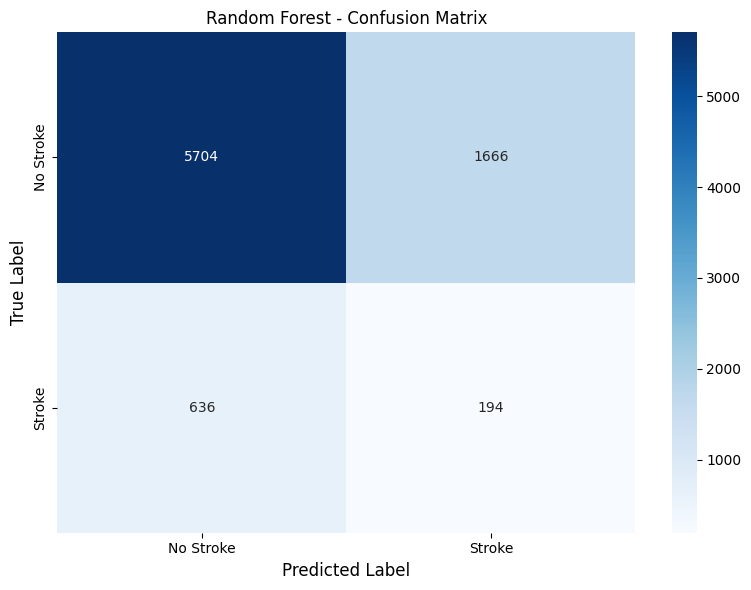


Random Forest-Confusion Matrix:
Total samples: 8200
Correctly classified: 5898 (71.9%)
Misclassified: 2302 (28.1%)
Specificity (True Negative Rate): 0.774
Sensitivity (True Positive Rate): 0.234


In [12]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Stroke', 'Stroke'], 
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Random Forest - Confusion Matrix', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\nRandom Forest-Confusion Matrix:")
print(f"Total samples: {cm.sum()}")
print(f"Correctly classified: {cm[0,0] + cm[1,1]} ({(cm[0,0] + cm[1,1])/cm.sum()*100:.1f}%)")
print(f"Misclassified: {cm[0,1] + cm[1,0]} ({(cm[0,1] + cm[1,0])/cm.sum()*100:.1f}%)")
print(f"Specificity (True Negative Rate): {cm[0,0]/(cm[0,0] + cm[0,1]):.3f}")
print(f"Sensitivity (True Positive Rate): {cm[1,1]/(cm[1,1] + cm[1,0]):.3f}")


## Save the Corrected Model


In [14]:
model_package = {
    'model': rf_model,
    'scaler': scaler,
    'feature_names': feature_names,
    'version': '3.0_corrected',
    'training_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'smote_applied': True,
    'preprocessing_notes': 'SMOTE applied only to training data to prevent data leakage'
}

with open("../models/random_forest.pkl", "wb") as f:
    pickle.dump(model_package, f)

print(f"Model saved to: models/random_forest.pkl")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Expected {len(feature_names)} features in order: {feature_names}")



Model saved to: models/random_forest.pkl
Test accuracy: 0.7193
F1 Score: 0.1442
Expected 16 features in order: ['Age', 'Sex', 'Hypertension', 'Heart_Disease', 'Work_Type', 'Residence_Type', 'Average_Glucose_Level', 'BMI', 'Smoking_Status', 'Physical_Activity', 'Alcohol_Intake', 'Stress_Level', 'Blood_Pressure', 'Cholesterol', 'Family_History', 'MRI_Result']
